In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random, math
import sys

In [51]:
class Solution():    
    #structure of the solution 
    def __init__(self):
        self.N_vetices = None
        self.num_agents = None
        self.max_iter = None
        self.obj_function = None
        self.execution_time = None
        self.convergence_curve = {}
        self.best_agent = None
        self.best_fitness = None
        self.best_accuracy = None
        self.final_population = None
        self.final_fitness = None
        self.final_accuracy = None

def initialize(num_agents, N_vertices):

    agents = np.zeros((num_agents,N_vertices))

    for agent_no in range(num_agents):
      agents[agent_no] = np.random.choice([0, 1], size=N_vertices, p=[.5, .5])
      
    return agents


def sort_agents(agents, obj_function, graph):

    # if there is only one agent
    if len(agents.shape) == 1:
        num_agents = 1
        fitness = obj_function(agents, graph)
        return agents, fitness

    # for multiple agents
    else:
        num_agents = agents.shape[0]
        fitness = np.zeros(num_agents)
        for id, agent in enumerate(agents):
            fitness[id] = obj_function(agent, graph)
        idx = np.argsort(-fitness)
        sorted_agents = agents[idx].copy()
        sorted_fitness = fitness[idx].copy()

    return sorted_agents, sorted_fitness

def cycle_cost(agent, graph):
  encoding = np.argsort(np.argsort(agent)) #gives sorted rank of each element, eg: [0.2, 0.5, 0.1, 0.9] -> [1 2 0 3]
  cycle = np.append(encoding,encoding[0])
  cost = 0
  for i in range(0, len(cycle)-1):
    cost = cost + graph[cycle[i]][cycle[i+1]]
  return -cost

def display(agents, fitness, agent_name='Agent'):
    # display the population
    print('\nNumber of agents: {}'.format(agents.shape[0]))
    print('\n------------- Best Agent ---------------')
    print('Fitness: {}'.format(fitness[0]))
    print('----------------------------------------\n')

    for id, agent in enumerate(agents):
        print('{} {} - Fitness: {}'.format(agent_name, id+1, fitness[id]))

    print('================================================================================\n')


In [70]:
def RDA(num_agents, max_iter, graph, N_vertices, obj_function=cycle_cost, save_conv_graph=False):

    # Red Deer Algorithm
    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of red deers                                           #
    #   max_iter: maximum number of generations                                   #      
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################
    
    # Number of agents must be at least 8
    if num_agents < 8:
        print("[Error!] The value of the parameter num_agents must be at least 8", file=sys.stderr)
        sys.exit(1)
        
    short_name = 'RDA'
    agent_name = 'RedDeer'
    
    
    # initialize red deers and Leader (the agent with the max fitness)
    deer = initialize(num_agents, N_vertices)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, N_vertices))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)
    convergence_curve['feature_count'] = np.zeros(max_iter)

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.N_vertices = N_vertices
    solution.obj_function = obj_function
    
    # initializing parameters
    UB = 5 # Upper bound
    LB = -5 # Lower bound
    gamma = 0.5 # Fraction of total number of males who are chosen as commanders
    alpha = 0.2 # Fraction of total number of hinds in a harem who mate with the commander of their harem
    beta = 0.1 # Fraction of total number of hinds in a harem who mate with the commander of a different harem

    # start timer
    start_time = time.time()

    # main loop
    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')
        
        deer, fitness = sort_agents(deer, obj_function, graph)
        num_males = int(0.25 * num_agents)
        num_hinds = num_agents - num_males
        males = deer[:num_males,:]
        hinds = deer[num_males:,:]
        
        # roaring of male deer
        for i in range(num_males):
            r1 = np.random.random() # r1 is a random number in [0, 1]
            r2 = np.random.random() # r2 is a random number in [0, 1]
            r3 = np.random.random() # r3 is a random number in [0, 1]
            new_male = males[i].copy()
            if r3 >= 0.5:                                    # Eq. (3)
                new_male += r1 * (((UB - LB) * r2) + LB)
            else:
                new_male -= r1 * (((UB - LB) * r2) + LB)
                    
            if obj_function(new_male, graph) < obj_function(males[i], graph):
                males[i] = new_male
        
        
        # selection of male commanders and stags
        num_coms = int(num_males * gamma) # Eq. (4)
        num_stags = num_males - num_coms # Eq. (5)

        coms = males[:num_coms,:]
        stags = males[num_coms:,:]
        
        # fight between male commanders and stags       
        for i in range(num_coms):
            chosen_com = coms[i].copy()
            chosen_stag = random.choice(stags)
            r1 = np.random.random()
            r2 = np.random.random()
            new_male_1 = (chosen_com + chosen_stag) / 2 + r1 * (((UB - LB) * r2) + LB) # Eq. (6)
            new_male_2 = (chosen_com + chosen_stag) / 2 - r1 * (((UB - LB) * r2) + LB) # Eq. (7)
                    
            fitness = np.zeros(4)
            fitness[0] = obj_function(chosen_com, graph)
            fitness[1] = obj_function(chosen_stag, graph)
            fitness[2] = obj_function(new_male_1, graph)
            fitness[3] = obj_function(new_male_2, graph)
            
            bestfit = np.max(fitness)
            if fitness[0] < fitness[1] and fitness[1] == bestfit:
                coms[i] = chosen_stag.copy()
            elif fitness[0] < fitness[2] and fitness[2] == bestfit:
                coms[i] = new_male_1.copy()
            elif fitness[0] < fitness[3] and fitness[3] == bestfit:
                coms[i] = new_male_2.copy()

        # formation of harems
        coms, fitness = sort_agents(coms, obj_function, graph)
        norm = np.linalg.norm(fitness)
        normal_fit = fitness / norm
        total = np.sum(normal_fit)
        power = normal_fit / total # Eq. (9)
        num_harems = [int(x * num_hinds) for x in power] # Eq.(10)
        max_harem_size = np.max(num_harems)
        harem = np.empty(shape=(num_coms, max_harem_size, N_vertices))
        random.shuffle(hinds)
        itr = 0
        for i in range(num_coms):
            harem_size = num_harems[i]
            for j in range(harem_size):
                harem[i][j] = hinds[itr]
                itr += 1
        
        # mating of commander with hinds in his harem
        num_harem_mate = [int(x * alpha) for x in num_harems] # Eq. (11)
        population_pool = list(deer)
        for i in range(num_coms):
            random.shuffle(harem[i])
            for j in range(num_harem_mate[i]):
                r = np.random.random() # r is a random number in [0, 1]
                offspring = (coms[i] + harem[i][j]) / 2 + (UB - LB) * r # Eq. (12)
                
                population_pool.append(list(offspring))
                
                # if number of commanders is greater than 1, inter-harem mating takes place
                if num_coms > 1:
                    # mating of commander with hinds in another harem
                    k = i 
                    while k == i:
                        k = random.choice(range(num_coms))

                    num_mate = int(num_harems[k] * beta) # Eq. (13)

                    np.random.shuffle(harem[k])
                    for j in range(num_mate):
                        r = np.random.random() # r is a random number in [0, 1]
                        offspring = (coms[i] + harem[k][j]) / 2 + (UB - LB) * r 
                        population_pool.append(list(offspring))
        
        # mating of stag with nearest hind
        for stag in stags:
            dist = np.zeros(num_hinds)
            for i in range(num_hinds):
                dist[i] = math.sqrt(np.sum((stag-hinds[i])*(stag-hinds[i])))
            min_dist = np.min(dist)
            for i in range(num_hinds):
                distance = math.sqrt(np.sum((stag-hinds[i])*(stag-hinds[i]))) # Eq. (14)
                if(distance == min_dist):
                    r = np.random.random() # r is a random number in [0, 1]
                    offspring = (stag + hinds[i])/2 + (UB - LB) * r
                    population_pool.append(list(offspring))
                    
                    break
        
        # selection of the next generation
        population_pool = np.array(population_pool)            
        population_pool, fitness = sort_agents(population_pool, obj_function, graph)
        maximum = sum([f for f in fitness])
        selection_probs = [f/maximum for f in fitness]
        indices = np.random.choice(len(population_pool), size=num_agents, replace=True, p=selection_probs)          
        deer = population_pool[indices]
        
        # update final information
        deer, fitness = sort_agents(deer, obj_function, graph)
        display(deer, fitness, agent_name)
        if fitness[0] > Leader_fitness:
            Leader_agent = deer[0].copy()
            Leader_fitness = fitness[0].copy()
        convergence_curve['fitness'][iter_no] = Leader_fitness
        convergence_curve['feature_count'][iter_no] = int(np.sum(Leader_agent))

    # compute final accuracy
    Leader_agent, Leader_cost = sort_agents(Leader_agent, obj_function, graph)
    deer, accuracy = sort_agents(deer, obj_function, graph)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Lowest cost : {}'.format(-Leader_cost))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time
    
    # plot convergence curves
    iters = np.arange(max_iter)+1
    fig, axes = plt.subplots()
    fig.tight_layout(pad = 5) 
    fig.suptitle('Convergence Curves')
    
    axes.set_title('Convergence of Fitness over Iterations')
    axes.set_xlabel('Iteration')
    axes.set_ylabel('Fitness')
    axes.plot(iters, convergence_curve['fitness'])

    if(save_conv_graph):
        plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_population = deer
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time
    return solution

In [71]:
N_vertices = 4
graph = np.array([[0, 10, 15, 20],
                  [10, 0, 35, 25],
                  [15, 35, 0, 30],
                  [20, 25, 30, 0]])


                          Iteration - 1


Number of agents: 8

------------- Best Agent ---------------
Fitness: -80.0
----------------------------------------

RedDeer 1 - Fitness: -80.0
RedDeer 2 - Fitness: -80.0
RedDeer 3 - Fitness: -80.0
RedDeer 4 - Fitness: -80.0
RedDeer 5 - Fitness: -95.0
RedDeer 6 - Fitness: -95.0
RedDeer 7 - Fitness: -95.0
RedDeer 8 - Fitness: -95.0


                          Iteration - 2


Number of agents: 8

------------- Best Agent ---------------
Fitness: -80.0
----------------------------------------

RedDeer 1 - Fitness: -80.0
RedDeer 2 - Fitness: -80.0
RedDeer 3 - Fitness: -80.0
RedDeer 4 - Fitness: -80.0
RedDeer 5 - Fitness: -95.0
RedDeer 6 - Fitness: -95.0
RedDeer 7 - Fitness: -95.0
RedDeer 8 - Fitness: -95.0


                          Iteration - 3


Number of agents: 8

------------- Best Agent ---------------
Fitness: -80.0
----------------------------------------

RedDeer 1 - Fitness: -80.0
RedDeer 2 - Fitness: -80.0
RedDeer 3 - Fitness: -80.0

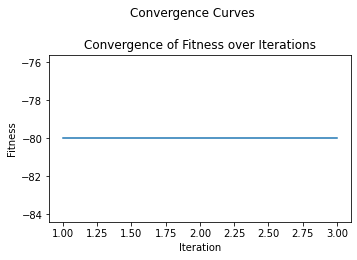

In [72]:
solution = RDA(num_agents=8, max_iter=3, graph=graph, N_vertices=N_vertices, obj_function=cycle_cost, save_conv_graph=True)